In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from gensim.models import KeyedVectors
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

# 检查系统中可用的中文字体
chinese_fonts = [f.name for f in fm.fontManager.ttflist if '黑体' in f.name or 'SimHei' in f.name or '宋体' in f.name or 'SimSun' in f.name]
print("可用的中文字体:", chinese_fonts)

# 尝试设置中文字体
if chinese_fonts:
    plt.rcParams['font.sans-serif'] = [chinese_fonts[0]] + plt.rcParams['font.sans-serif']
else:
    # 如果没有找到中文字体，尝试使用一些常见的中文字体名称
    plt.rcParams['font.sans-serif'] = ['SimHei', 'SimSun', 'NSimSun', 'FangSong', 'KaiTi', 'Microsoft YaHei'] + plt.rcParams['font.sans-serif']

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置更好的可视化风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# 定义项目根目录和模型目录
PROJECT_ROOT = Path.cwd().parent
MODELS_DIR = PROJECT_ROOT / "models"

# 可能的模型目录
FINE_TUNED_MODELS_DIR = MODELS_DIR / "fine_tuned_vectors_flexible"
SLIDING_WINDOW_MODELS_DIR = MODELS_DIR / "fine_tuned_vectors_sliding_window"

# 检查哪个目录存在并包含模型
if FINE_TUNED_MODELS_DIR.exists() and any(FINE_TUNED_MODELS_DIR.glob("*_wordvectors.kv")):
    MODELS_DIR = FINE_TUNED_MODELS_DIR
    print(f"使用固定时期模型目录: {MODELS_DIR}")
elif SLIDING_WINDOW_MODELS_DIR.exists():
    # 查找滑动窗口模型的子目录
    subdirs = [d for d in SLIDING_WINDOW_MODELS_DIR.iterdir() if d.is_dir()]
    if subdirs:
        MODELS_DIR = subdirs[0]  # 使用第一个子目录
        print(f"使用滑动窗口模型目录: {MODELS_DIR}")
    else:
        print(f"滑动窗口模型目录存在，但没有子目录")
else:
    print(f"未找到模型目录，使用默认路径: {MODELS_DIR}")

# 加载所有可用的模型
def load_models():
    """加载目录中所有的词向量模型"""
    models = {}
    model_files = list(MODELS_DIR.glob("*_wordvectors.kv"))
    
    if not model_files:
        print(f"在 {MODELS_DIR} 中没有找到模型文件")
        return models
    
    print(f"找到 {len(model_files)} 个模型文件:")
    for model_file in sorted(model_files):
        period_name = model_file.stem.replace("_wordvectors", "")
        print(f"  加载模型: {period_name}")
        try:
            models[period_name] = KeyedVectors.load(str(model_file))
            print(f"  成功加载 {period_name}, 词汇量: {len(models[period_name].index_to_key)}")
        except Exception as e:
            print(f"  加载 {period_name} 失败: {e}")
    
    return models

# 加载模型
models = load_models()

# 检查模型是否成功加载
if not models:
    print("没有成功加载任何模型，请检查模型路径")
else:
    print(f"\n成功加载了 {len(models)} 个模型:")
    for period_name, model in models.items():
        print(f"  {period_name}: 词汇量 {len(model.index_to_key)}")

可用的中文字体: ['SimHei']
使用固定时期模型目录: /home/fangshikai/law-word-vector/models/fine_tuned_vectors_flexible
找到 3 个模型文件:
  加载模型: Era1_1978-1996
  成功加载 Era1_1978-1996, 词汇量: 4874
  加载模型: Era2_1997-2013
  成功加载 Era2_1997-2013, 词汇量: 4992
  加载模型: Era3_2014-2024
  成功加载 Era3_2014-2024, 词汇量: 5000

成功加载了 3 个模型:
  Era1_1978-1996: 词汇量 4874
  Era2_1997-2013: 词汇量 4992
  Era3_2014-2024: 词汇量 5000


In [4]:
def save_similar_words(models, keyword="法治", topn=20, output_dir="similar_words"):
    """
    保存每个时期模型中与关键词最相似的词
    
    Args:
        models: 词向量模型字典
        keyword: 要查询的关键词，默认为"法治"
        topn: 返回最相似词的数量，默认20个
        output_dir: 输出文件保存的目录名，默认为"similar_words"
    """
    # 创建输出目录
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    for period_name, model in models.items():
        # 检查关键词是否在词汇表中
        if keyword not in model:
            print(f"警告: 关键词'{keyword}'在{period_name}模型中不存在")
            continue
            
        try:
            # 获取最相似的词
            similar_words = model.most_similar(keyword, topn=topn)
            
            # 保存到文件
            output_file = output_path / f"{period_name}_similar_words_top{topn}.txt"
            with open(output_file, "w", encoding="utf-8") as f:
                f.write(f"与'{keyword}'最相似的{topn}个词 ({period_name}):\n\n")
                for word, score in similar_words:
                    f.write(f"{word}\t{score:.4f}\n")
                    
            print(f"已保存{period_name}的相似词到: {output_file}")
            
        except Exception as e:
            print(f"处理{period_name}时出错: {e}")
            
    print("\n完成所有时期相似词的保存")

# 使用示例
save_similar_words(models, keyword="法治", topn=5000, output_dir="similar_words")


已保存Era1_1978-1996的相似词到: similar_words/Era1_1978-1996_similar_words_top5000.txt
已保存Era2_1997-2013的相似词到: similar_words/Era2_1997-2013_similar_words_top5000.txt
已保存Era3_2014-2024的相似词到: similar_words/Era3_2014-2024_similar_words_top5000.txt

完成所有时期相似词的保存


In [ ]:
# import matplotlib.font_manager as fm
# import requests  # 添加这个导入
# # 下载中文字体
# def download_chinese_font():
#     """下载中文字体并安装到matplotlib"""
#     font_url = "https://github.com/StellarCN/scp_zh/raw/master/fonts/SimHei.ttf"
#     font_path = os.path.join(os.path.expanduser("~"), ".fonts", "SimHei.ttf")
    
#     # 创建目录
#     os.makedirs(os.path.dirname(font_path), exist_ok=True)
    
#     # 如果字体已存在，则不下载
#     if os.path.exists(font_path):
#         print(f"字体已存在: {font_path}")
#     else:
#         print(f"下载中文字体到: {font_path}")
#         try:
#             response = requests.get(font_url)
#             with open(font_path, 'wb') as f:
#                 f.write(response.content)
#             print("字体下载成功")
#         except Exception as e:
#             print(f"下载字体时出错: {e}")
#             return None
    
#     # 刷新matplotlib字体缓存
#     print("刷新字体缓存...")
#     fm.fontManager.addfont(font_path)
#     fm._load_fontmanager(try_read_cache=False)
    
#     return font_path

# # 下载并安装字体
# font_path = download_chinese_font()

# # 设置matplotlib使用下载的字体
# if font_path:
#     plt.rcParams['font.sans-serif'] = ['SimHei'] + plt.rcParams['font.sans-serif']
#     print("成功设置中文字体")
# else:
#     print("无法设置中文字体，将使用替代方案")



下载中文字体到: /home/fangshikai/.fonts/SimHei.ttf


字体下载成功
刷新字体缓存...
成功设置中文字体


In [2]:
models

{'Era1_1978-1996': <gensim.models.keyedvectors.KeyedVectors at 0x7e8f8e58b970>,
 'Era2_1997-2013': <gensim.models.keyedvectors.KeyedVectors at 0x7e8f8c8085e0>,
 'Era3_2014-2024': <gensim.models.keyedvectors.KeyedVectors at 0x7e8f8c8088e0>}

In [25]:
def visualize_similar_words_across_periods(similar_words_by_period, focus_word, top_n=20, exclude_words_path=None):
    """
    可视化不同时期相似词的变化
    
    参数:
    similar_words_by_period: 字典，键为时期名称，值为(word, similarity)元组列表
    focus_word: 焦点词
    top_n: 每个时期要显示的前N个相似词
    exclude_words_path: 排除词库的文件路径，文件中每行一个词
    """
    if not similar_words_by_period:
        print("没有数据可供可视化")
        return
    
    # 加载排除词库
    exclude_words = set()
    if exclude_words_path:
        try:
            with open(exclude_words_path, 'r', encoding='utf-8') as f:
                exclude_words = set(line.strip() for line in f if line.strip())
            print(f"已加载 {len(exclude_words)} 个排除词")
        except Exception as e:
            print(f"加载排除词库时出错: {e}")
    
    # 准备数据
    periods = list(similar_words_by_period.keys())
    
    # 创建一个包含所有时期前top_n个相似词的列表（排除指定词）
    all_top_words = []
    
    # 首先，为每个时期过滤掉排除词
    filtered_similar_words = {}
    for period in periods:
        # 过滤掉排除词
        filtered_words = [(word, sim) for word, sim in similar_words_by_period[period] 
                         if word not in exclude_words]
        filtered_similar_words[period] = filtered_words
    
    # 然后，从过滤后的列表中获取前top_n个词
    for period in periods:
        top_words = [word for word, _ in filtered_similar_words[period][:top_n]]
        for word in top_words:
            if word not in all_top_words:  # 避免重复
                all_top_words.append(word)
    
    # 如果没有词语可以显示，则返回
    if not all_top_words:
        print("过滤后没有词语可以显示")
        return None
    
    # 创建一个DataFrame来存储每个时期每个词的相似度
    df = pd.DataFrame(index=all_top_words, columns=periods)
    
    # 填充DataFrame
    for period in periods:
        word_sim_dict = dict(filtered_similar_words[period])
        for word in all_top_words:
            df.loc[word, period] = word_sim_dict.get(word, 0)
    
    # 确保所有值都是浮点数
    df = df.astype(float)
    
    # 按照在最后一个时期的相似度排序
    if len(periods) > 0:
        last_period = periods[-1]
        df = df.sort_values(by=last_period, ascending=False)
    
    # 绘制热力图
    plt.figure(figsize=(12, len(all_top_words) * 0.3 + 2))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5)
    plt.title(f"与'{focus_word}'相似度最高的{top_n}个词在不同时期的变化（已排除{len(exclude_words)}个词）")
    plt.tight_layout()
    plt.show()
    
    return df

In [23]:
# 创建一个示例排除词库文件
# exclude_words_path = "exclude_words.txt"

# # 写入一些示例排除词
# with open(exclude_words_path, 'w', encoding='utf-8') as f:
#     # 这里可以添加你想要排除的词
#     # 例如，你可能想排除一些常见词或无关词
#     f.write("的\n是\n在\n和\n了\n与\n等\n对\n以\n为\n")

已加载 17 个排除词


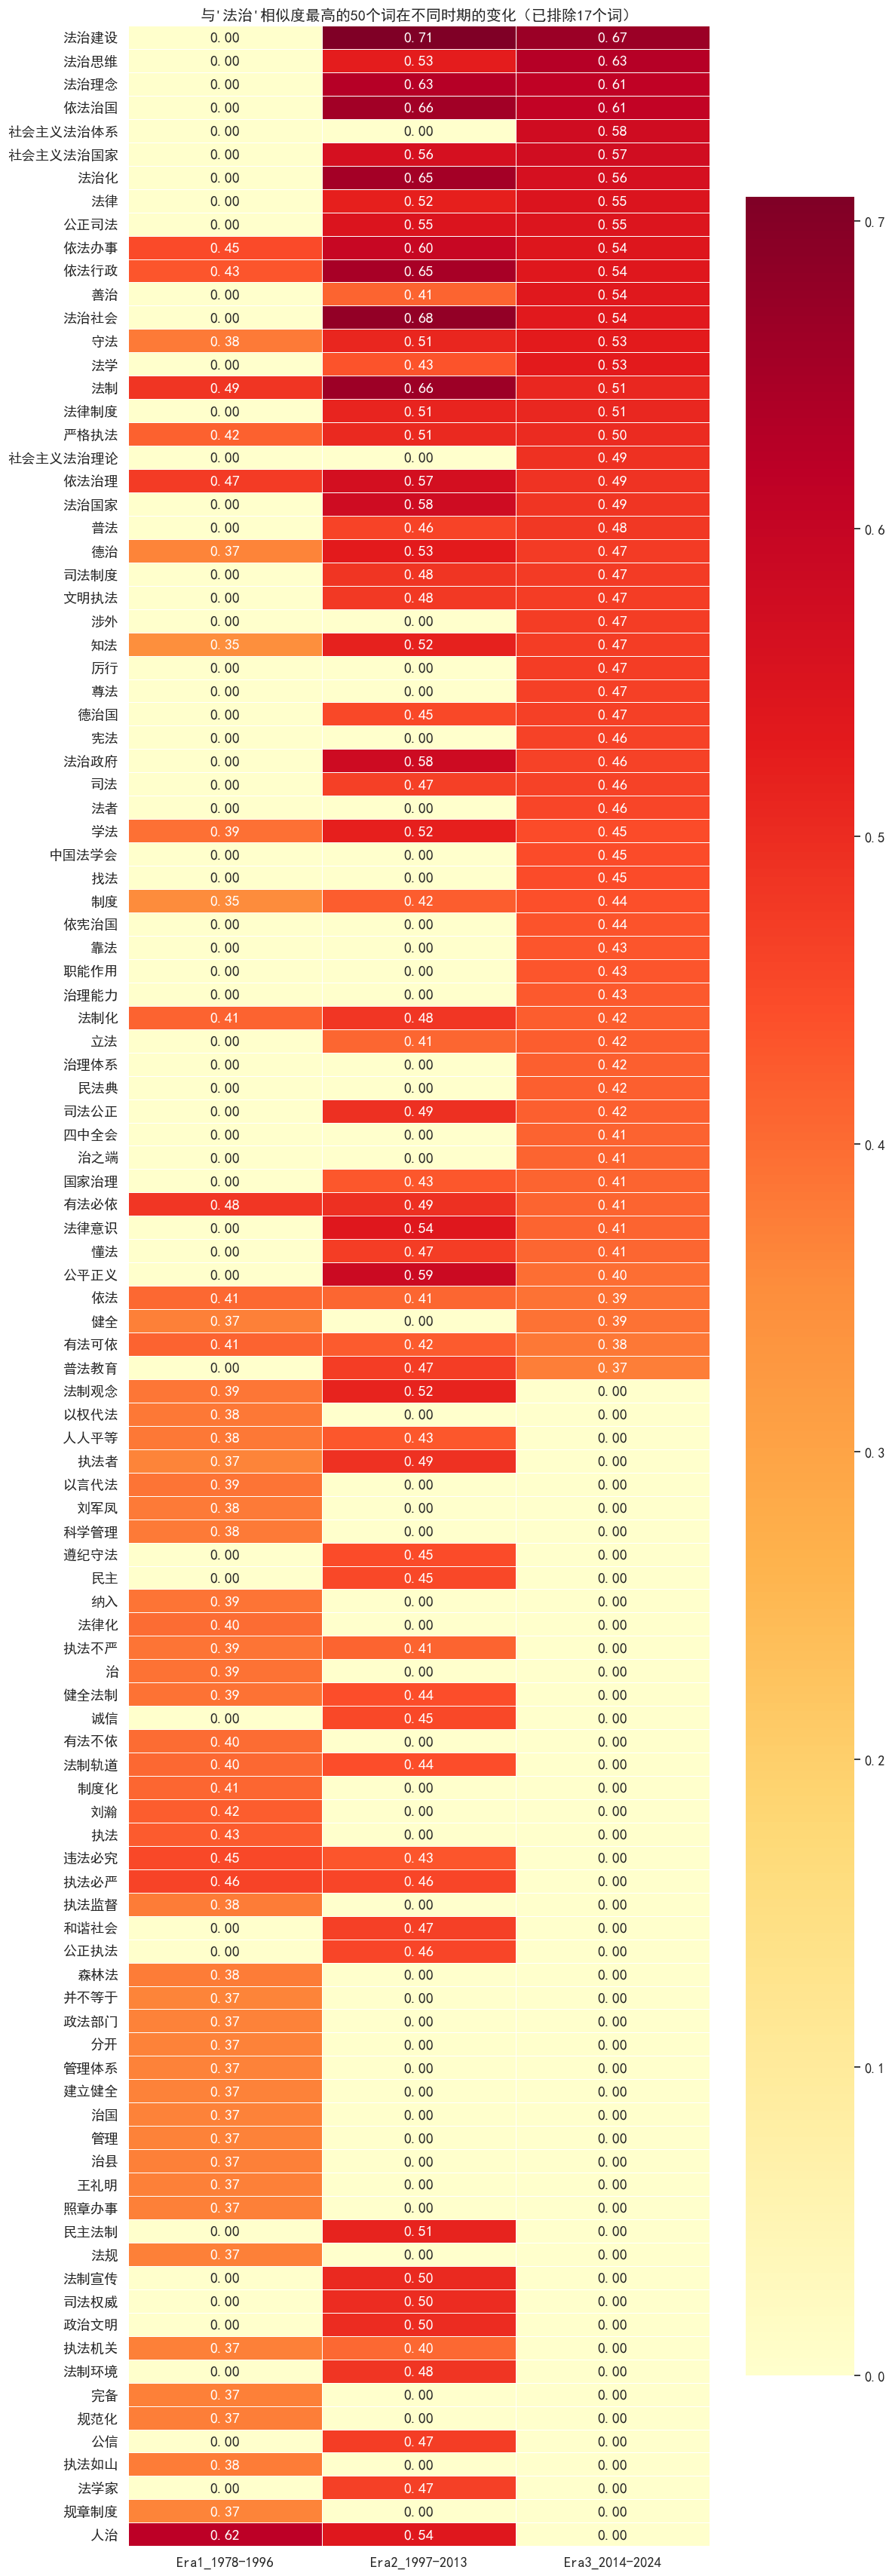

In [32]:
similarity_df = visualize_similar_words_across_periods(
    similar_words_by_period, 
    focus_word, 
    top_n=50, 
    exclude_words_path=exclude_words_path
)

In [29]:
def get_common_top_words(similar_words_by_period, top_n=50, exclude_words_path=None):
    """
    获取所有时期中前N个相似词的并集
    
    参数:
    similar_words_by_period: 字典，键为时期名称，值为(word, similarity)元组列表
    top_n: 每个时期要考虑的前N个相似词
    exclude_words_path: 排除词库的文件路径，文件中每行一个词
    
    返回:
    common_words: 所有时期前N个相似词的并集
    filtered_similar_words: 过滤后的相似词字典
    """
    if not similar_words_by_period:
        print("没有数据可供分析")
        return [], {}
    
    # 加载排除词库
    exclude_words = set()
    if exclude_words_path:
        try:
            with open(exclude_words_path, 'r', encoding='utf-8') as f:
                exclude_words = set(line.strip() for line in f if line.strip())
            print(f"已加载 {len(exclude_words)} 个排除词")
        except Exception as e:
            print(f"加载排除词库时出错: {e}")
    
    # 准备数据
    periods = list(similar_words_by_period.keys())
    
    # 为每个时期过滤掉排除词
    filtered_similar_words = {}
    for period in periods:
        # 过滤掉排除词
        filtered_words = [(word, sim) for word, sim in similar_words_by_period[period] 
                         if word not in exclude_words]
        filtered_similar_words[period] = filtered_words
    
    # 获取每个时期前top_n个词的并集
    common_words = []
    for period in periods:
        top_words = [word for word, _ in filtered_similar_words[period][:top_n]]
        for word in top_words:
            if word not in common_words:  # 避免重复
                common_words.append(word)
    
    print(f"所有时期前{top_n}个相似词的并集包含 {len(common_words)} 个词")
    return common_words, filtered_similar_words

def visualize_relative_similarity(similar_words_by_period, focus_word, common_words, filtered_similar_words=None, top_n=30):
    """
    可视化不同时期相似词的相对相似度
    
    参数:
    similar_words_by_period: 字典，键为时期名称，值为(word, similarity)元组列表
    focus_word: 焦点词
    common_words: 所有时期前N个相似词的并集
    filtered_similar_words: 过滤后的相似词字典，如果为None则使用similar_words_by_period
    top_n: 最终要显示的词数量
    """
    if not similar_words_by_period:
        print("没有数据可供可视化")
        return
    
    # 如果没有提供过滤后的相似词，则使用原始相似词
    if filtered_similar_words is None:
        filtered_similar_words = similar_words_by_period
    
    # 准备数据
    periods = list(similar_words_by_period.keys())
    
    # 限制common_words的数量，以便更好地可视化
    if len(common_words) > top_n:
        # 计算每个词在所有时期的平均相似度
        word_avg_sim = {}
        for word in common_words:
            sims = []
            for period in periods:
                word_sim_dict = dict(filtered_similar_words[period])
                if word in word_sim_dict:
                    sims.append(word_sim_dict[word])
            if sims:
                word_avg_sim[word] = sum(sims) / len(sims)
        
        # 按平均相似度排序，取前top_n个词
        common_words = sorted(word_avg_sim.keys(), key=lambda w: word_avg_sim[w], reverse=True)[:top_n]
    
    # 创建一个DataFrame来存储每个时期每个词的相似度
    df_raw = pd.DataFrame(index=common_words, columns=periods)
    
    # 填充原始相似度DataFrame
    for period in periods:
        word_sim_dict = dict(filtered_similar_words[period])
        for word in common_words:
            df_raw.loc[word, period] = word_sim_dict.get(word, 0)
    
    # 确保所有值都是浮点数
    df_raw = df_raw.astype(float)
    
    # 计算相对相似度
    # 相对相似度 = 当前时期相似度 / 所有时期该词的最大相似度
    df_relative = pd.DataFrame(index=common_words, columns=periods)
    
    for word in common_words:
        max_sim = df_raw.loc[word].max()
        if max_sim > 0:  # 避免除以零
            for period in periods:
                df_relative.loc[word, period] = df_raw.loc[word, period] / max_sim
        else:
            for period in periods:
                df_relative.loc[word, period] = 0
    
    # 确保相对相似度DataFrame中的所有值都是浮点数
    df_relative = df_relative.astype(float)
    
    # 按照在最后一个时期的相对相似度排序
    if len(periods) > 0:
        last_period = periods[-1]
        df_relative = df_relative.sort_values(by=last_period, ascending=False)
    
    # 绘制热力图 - 原始相似度
    plt.figure(figsize=(12, len(common_words) * 0.3 + 2))
    sns.heatmap(df_raw, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5)
    plt.title(f"与'{focus_word}'的原始相似度 (共{len(common_words)}个词)")
    plt.tight_layout()
    plt.show()
    
    # 绘制热力图 - 相对相似度
    plt.figure(figsize=(12, len(common_words) * 0.3 + 2))
    sns.heatmap(df_relative, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5, vmin=0, vmax=1)
    plt.title(f"与'{focus_word}'的相对相似度 (共{len(common_words)}个词)")
    plt.tight_layout()
    plt.show()
    
    return df_raw, df_relative

已加载 17 个排除词
所有时期前50个相似词的并集包含 108 个词


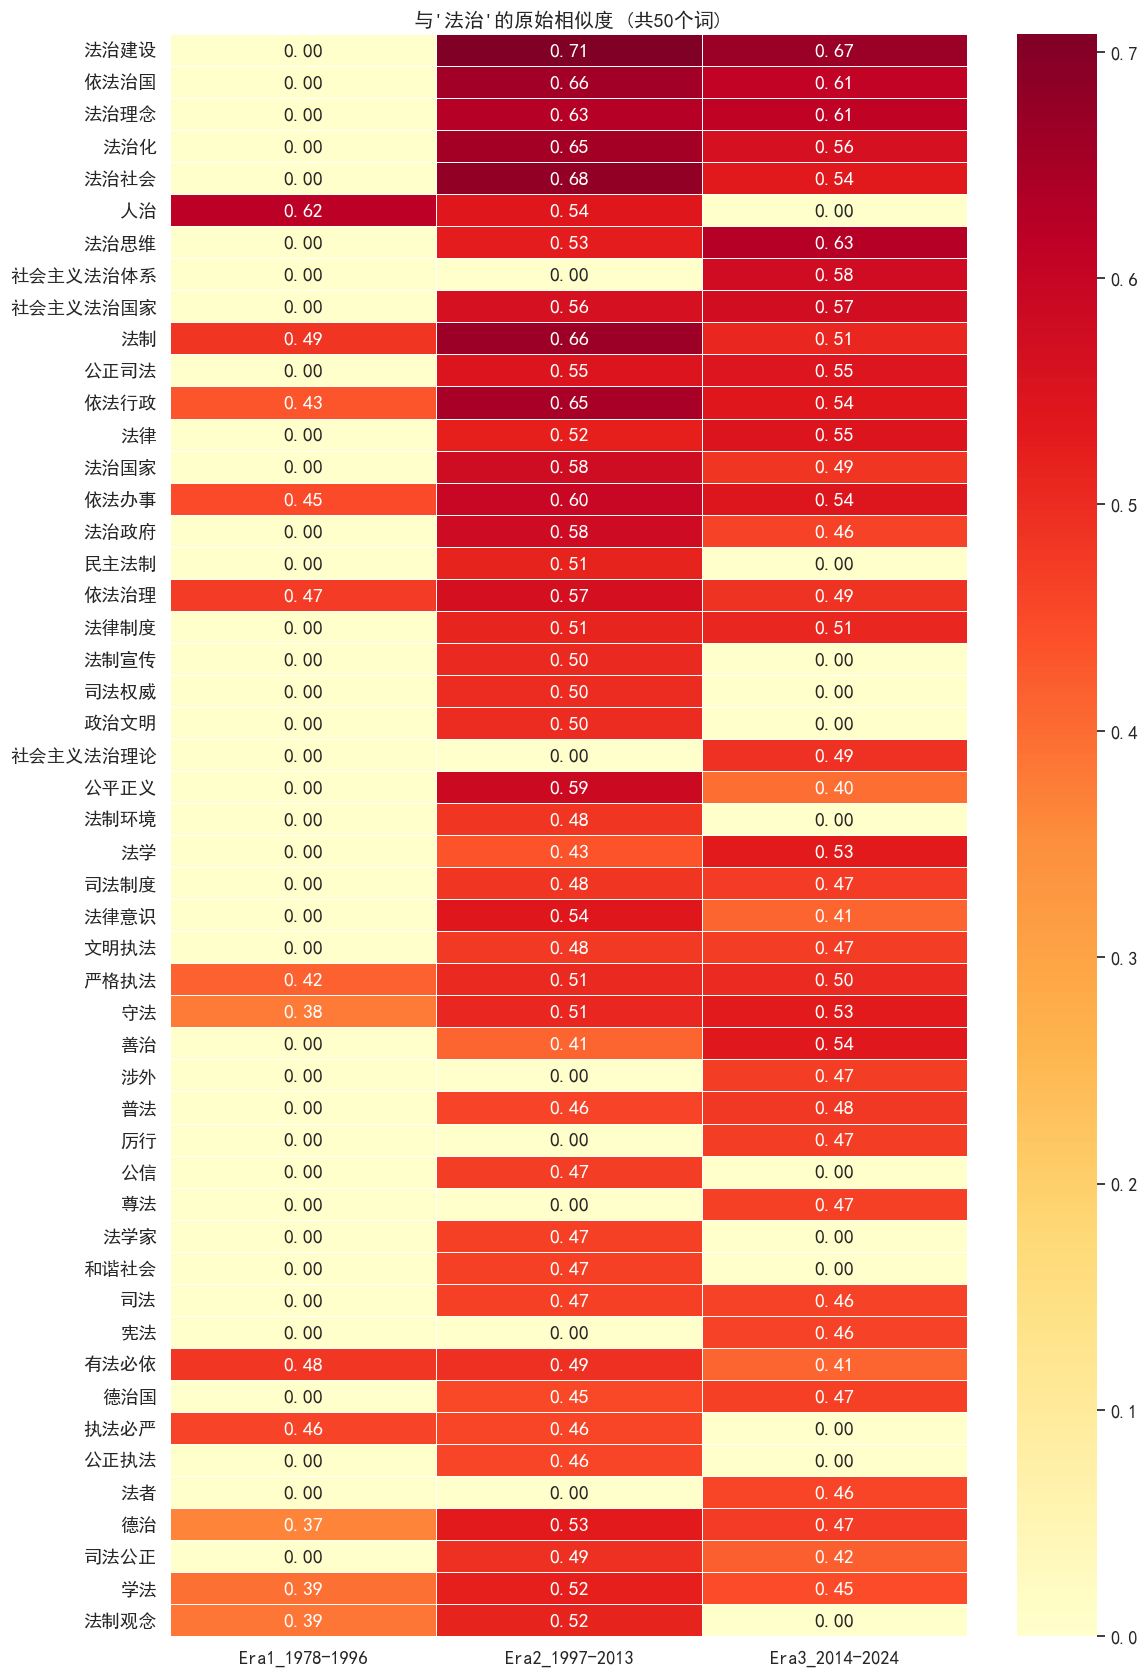

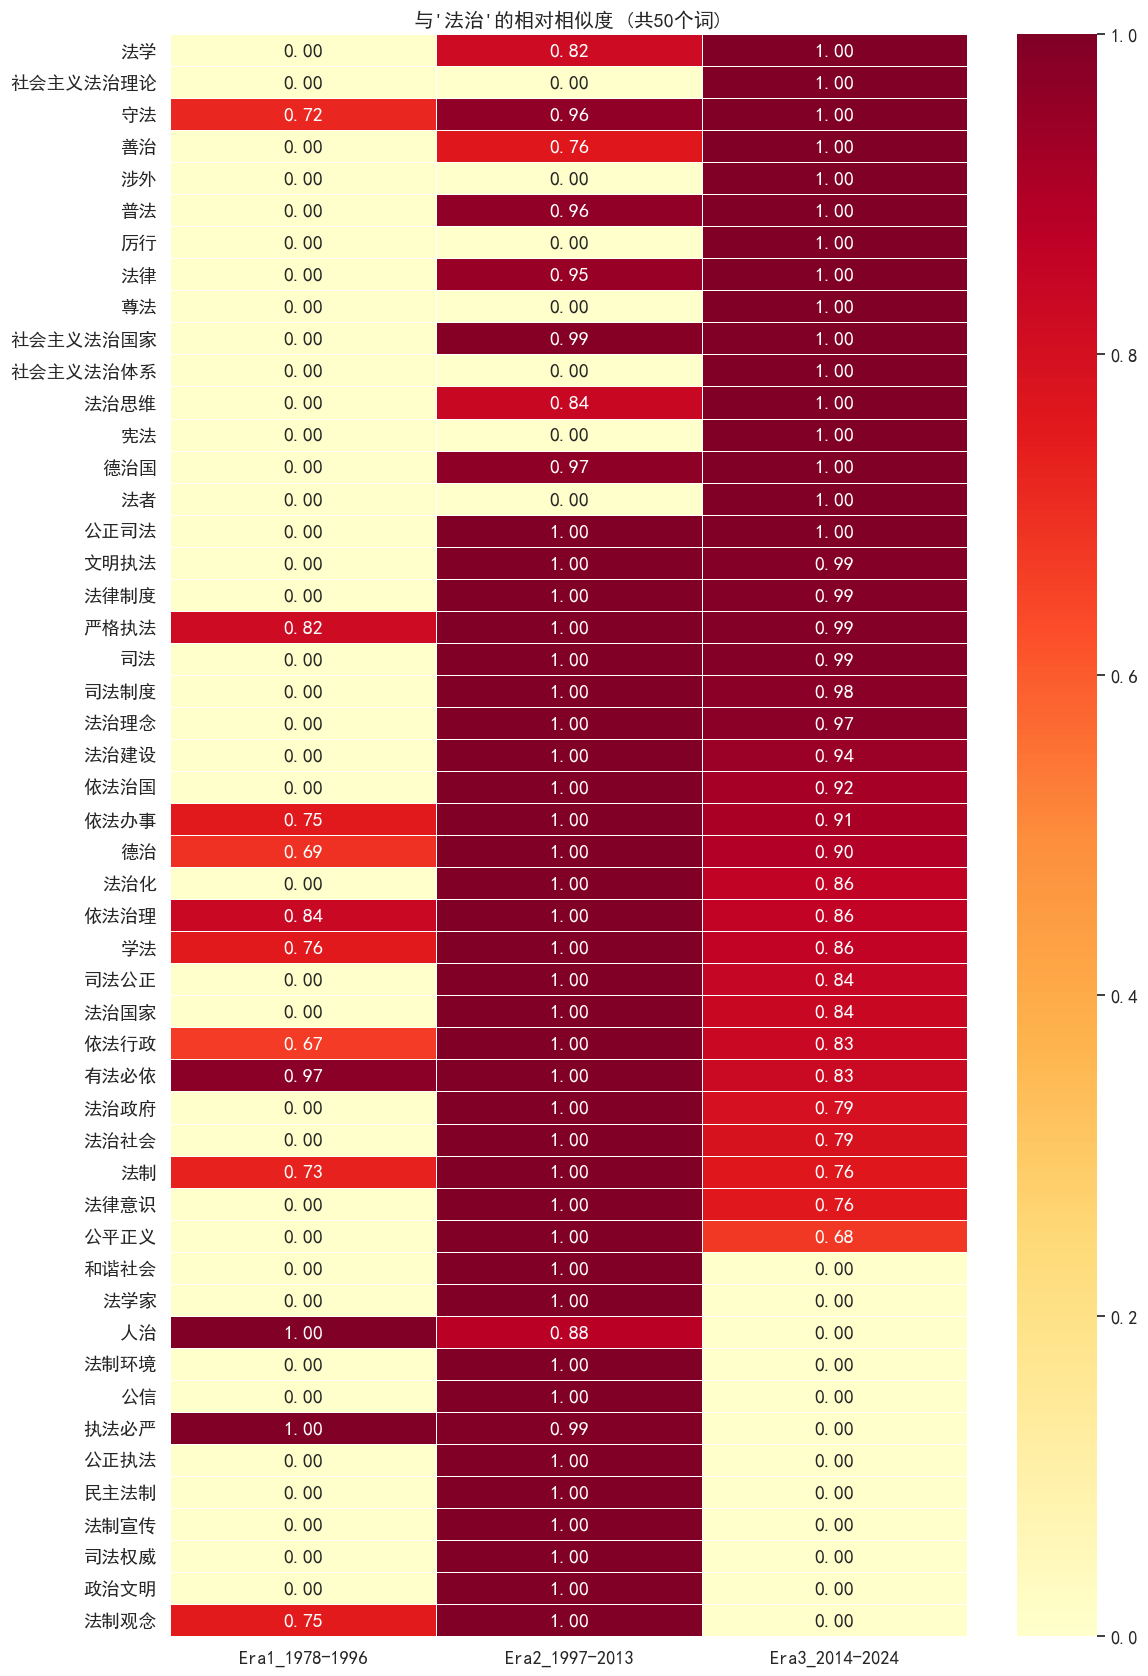

In [ ]:
# 获取共同词集合
common_words, filtered_similar_words = get_common_top_words(
    similar_words_by_period, 
    top_n=100,  # 每个时期考虑前50个词
    exclude_words_path=exclude_words_path
)

# 可视化相对相似度
raw_df, relative_df = visualize_relative_similarity(
    similar_words_by_period,
    focus_word,
    common_words,
    filtered_similar_words,
    top_n=100  # 最终显示前30个词
)